# Task 7

## References

- https://towardsdatascience.com/transfer-learning-with-a-one-dimensional-signal-76a0d543e9aa
- https://keras.io/api/applications/
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16
- https://medium.com/@sajals1146/vgg-net-architecture-880df59c37ea
- https://medium.com/featurepreneur/image-data-augmentation-using-keras-imagedatagenerator-1cee60255ea8
- https://www.geeksforgeeks.org/python-os-open-method/
- https://pillow.readthedocs.io/en/stable/handbook/index.html#
- https://docs.python.org/3/library/os.html


## Import

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121 , Xception , MobileNet , ResNet50 , VGG16 , VGG19

C:\Users\manas\AppData\Local\Temp\ipykernel_19632\3892930504.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Preprossesing Image

In [ ]:
train_dir='Data/train'
val_dir = 'Data/validation'
test_dir='Data/test'

In [ ]:
import os
classes_train=os.listdir(train_dir)
classes_val = os.listdir(val_dir)
classes_test=os.listdir(test_dir)

In [ ]:
classes_train

['fist', 'five', 'none', 'okay', 'peace', 'rad', 'straight', 'thumbs']

In [ ]:
train_labels = ['fist', 'five' , 'none' , 'okay', 'peace', 'rad', 'straight' , 'thumbs']
class_train = {}
for label in train_labels:
    class_dir = os.path.join(train_dir, label)
    num_images = len(os.listdir(class_dir))
    class_train[label] = num_images
for label, count in class_train.items():
    print(f"Class: {label}, Number of Images: {count}")

Class: fist, Number of Images: 1000
Class: five, Number of Images: 1000
Class: none, Number of Images: 1000
Class: okay, Number of Images: 999
Class: peace, Number of Images: 1000
Class: rad, Number of Images: 1000
Class: straight, Number of Images: 1000
Class: thumbs, Number of Images: 1000


In [ ]:
classes_test

['fist', 'five', 'none', 'okay', 'peace', 'rad', 'straight', 'thumbs']

In [ ]:
test_labels = ['fist', 'five' , 'none' , 'okay', 'peace', 'rad', 'straight' , 'thumbs']
class_test = {}
for label2 in test_labels:
    class_dir2 = os.path.join(test_dir, label2)
    num_images2 = len(os.listdir(class_dir2))
    class_test[label2] = num_images2
for label2, count2 in class_test.items():
    print(f"Class: {label2}, Number of Images: {count2}")

Class: fist, Number of Images: 500
Class: five, Number of Images: 500
Class: none, Number of Images: 500
Class: okay, Number of Images: 500
Class: peace, Number of Images: 500
Class: rad, Number of Images: 500
Class: straight, Number of Images: 500
Class: thumbs, Number of Images: 500


In [ ]:
classes_val

['fist', 'five', 'none', 'okay', 'peace', 'rad', 'straight', 'thumbs']

In [ ]:
val_labels = ['fist', 'fist' , 'none' , 'okay', 'peace', 'rad', 'straight' , 'thumbs']
class_val = {}
for label3 in val_labels:
    class_dir3 = os.path.join(val_dir, label3)
    num_images3 = len(os.listdir(class_dir3))
    class_val[label3] = num_images3
for label3, count3 in class_val.items():
    print(f"Class: {label3}, Number of Images: {count3}")

Class: fist, Number of Images: 500
Class: none, Number of Images: 500
Class: okay, Number of Images: 500
Class: peace, Number of Images: 500
Class: rad, Number of Images: 500
Class: straight, Number of Images: 500
Class: thumbs, Number of Images: 499


In [ ]:
print("Training labels:", class_train.keys())
print("Test labels:", class_test.keys())
print("Validation labels:", class_val.keys())


Training labels: dict_keys(['fist', 'five', 'none', 'okay', 'peace', 'rad', 'straight', 'thumbs'])
Test labels: dict_keys(['fist', 'five', 'none', 'okay', 'peace', 'rad', 'straight', 'thumbs'])
Validation labels: dict_keys(['fist', 'none', 'okay', 'peace', 'rad', 'straight', 'thumbs'])


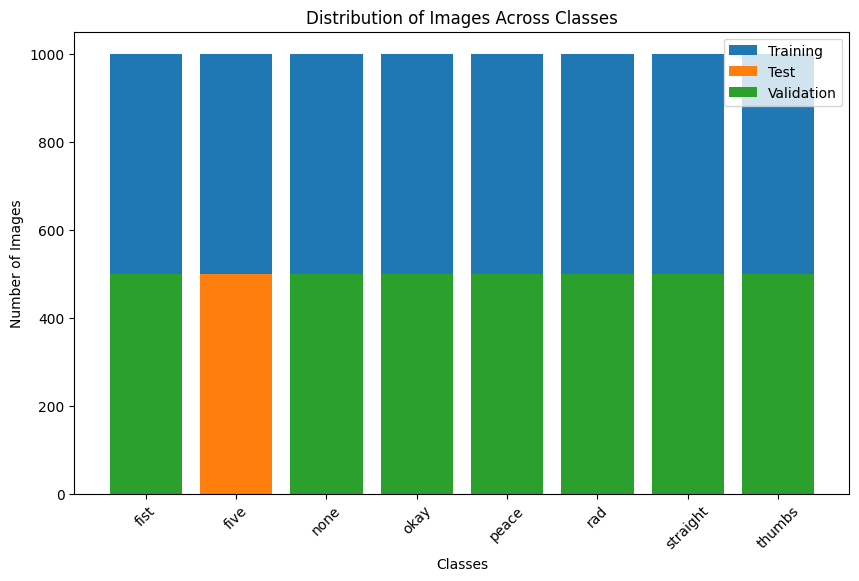

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(class_train.keys(), class_train.values(), label='Training')
plt.bar(class_test.keys(), class_test.values(), label='Test')
plt.bar(class_val.keys(), class_val.values(), label='Validation')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True

)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 7999 images belonging to 8 classes.


In [ ]:
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 3999 images belonging to 8 classes.


## Our Model

In [ ]:
early_stopping=EarlyStopping(patience=6 ,
                             monitor='val_accuracy',
                             restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(
monitor='val_accuracy',
patience=3,
verbose=1,
factor=0.5,
restore_best_weights=True,
min_lr=0.00001)

In [ ]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Use softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,072,968 (42.24 MB)

 Trainable params: 11,072,968 (42.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 820ms/step - accuracy: 0.3478 - loss: 1.6216 - val_accuracy: 0.8450 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 183s 726ms/step - accuracy: 0.7385 - loss: 0.6333 - val_accuracy: 0.9632 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 718ms/step - accuracy: 0.8418 - loss: 0.4161 - val_accuracy: 0.9907 - val_loss: 0.0413 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 718ms/step - accuracy: 0.8950 - loss: 0.2889 - val_accuracy: 0.9857 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 716ms/step - accuracy: 0.9256 - loss: 0.2174 - val_accuracy: 0.9875 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9398 - loss: 0.1882
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 715ms/step - acc

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.9951 - loss: 0.0182
Validation Loss: 0.01738174818456173
Validation Accuracy: 0.9949987530708313


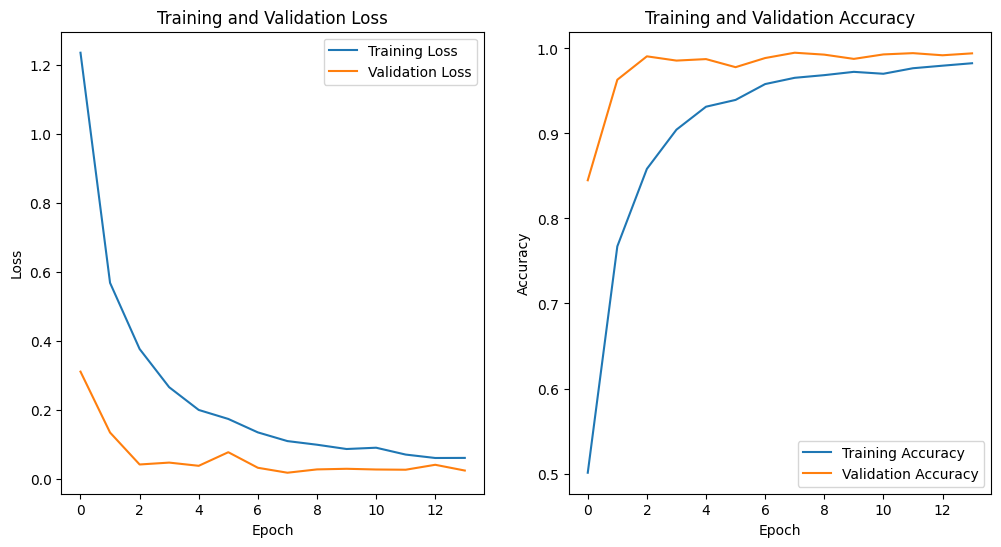

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 4000 images belonging to 8 classes.


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)

# Print the test accuracy and test loss
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 1.0000 - loss: 0.0073
Test Accuracy: 1.0
Test Loss: 0.007043247111141682


In [ ]:
model_path = "Model/model.keras"
model.save(model_path)
print("Model saved successfully at:", model_path)

Model saved successfully at: Model/model.keras


## Test Our Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(model_path)

In [ ]:
test_d='Data/test'

In [ ]:
class_labels = os.listdir(test_d)

In [ ]:
one_image_per_class = {}

In [ ]:
# Predict one from each classes

<Figure size 1500x1000 with 0 Axes>

In [ ]:
predicted_labels = []
true_labels = []

In [ ]:
for label in test_labels:
    class_dir = os.path.join(test_d, label)
    image_files = os.listdir(class_dir)

    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = Image.open(image_path).convert("RGB")  # Convert to RGB
        image = image.resize((256, 256))  # Resize to match model input shape
        image_array = np.array(image) / 255.0  # Normalize pixel values
        image_input = np.expand_dims(image_array, axis=0)  # Add batch dimension

        predicted_probabilities = model.predict(image_input)
        predicted_class_index = np.argmax(predicted_probabilities)
        predicted_class_label = class_labels[predicted_class_index]

        true_labels.append(label)
        predicted_labels.append(predicted_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

In [ ]:
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

In [ ]:
accuracy_model = np.mean(predicted_labels == true_labels)
print("Test Accuracy:", accuracy_model)

Test Accuracy: 1.0


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: 1.0


## Pre-Trained Model

In [ ]:
base_model= Xception(weights='imagenet',include_top=False,input_shape=(256,256,3))

In [ ]:
base_model.trainable = False

model_x = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model_x.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_x.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
history_desnet = model_x.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9782 - loss: 0.0681 - val_accuracy: 0.9862 - val_loss: 0.0537
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9806 - loss: 0.0554 - val_accuracy: 0.9865 - val_loss: 0.0508
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9776 - loss: 0.0613 - val_accuracy: 0.9887 - val_loss: 0.0409
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9755 - loss: 0.0668 - val_accuracy: 0.9862 - val_loss: 0.0537
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9740 - loss: 0.0622 - val_accuracy: 0.9862 - val_loss: 0.0584
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9826 - loss: 0.0526 - val_accuracy: 0.9875 - val_loss: 0.0534


In [ ]:
val_loss, val_accuracy = model_x.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9865 - loss: 0.0573
Validation Loss: 0.05365699902176857
Validation Accuracy: 0.9862465858459473


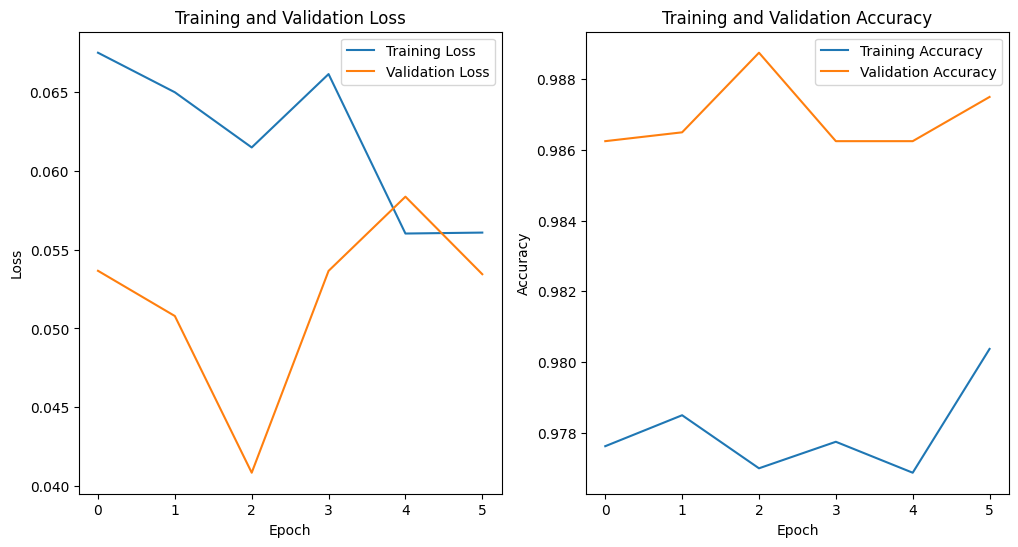

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_desnet.history['loss'], label='Training Loss')
plt.plot(history_desnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_desnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_desnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
test_loss, test_accuracy = model_x.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9943 - loss: 0.0383
Test Loss: 0.01831834763288498
Test Accuracy: 0.9977499842643738


In [ ]:
predicted_labels2 = []
true_labels2 = []

In [ ]:
for label2 in test_labels:
    class_dir2 = os.path.join(test_d, label2)
    image_files2 = os.listdir(class_dir2)

    for image_file2 in image_files2:  # Use image_files2 instead of image_files
        image_path2 = os.path.join(class_dir2, image_file2)
        image2 = Image.open(image_path2).convert("RGB")  # Convert to RGB
        image2 = image2.resize((256, 256))  # Resize to match model input shape
        image_array2 = np.array(image2) / 255.0  # Normalize pixel values
        image_input2 = np.expand_dims(image_array2, axis=0)  # Add batch dimension

        predicted_probabilities2 = model_x.predict(image_input2)
        predicted_class_index2 = np.argmax(predicted_probabilities2)
        predicted_class_label2 = class_labels[predicted_class_index2]

        true_labels2.append(label2)
        predicted_labels2.append(predicted_class_label2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

In [ ]:
predicted_labels2 = np.array(predicted_labels2)
true_labels2 = np.array(true_labels2)

In [ ]:
accuracy_model2 = np.mean(predicted_labels2 == true_labels2)
print("Test Accuracy:", accuracy_model2)

Test Accuracy: 0.99775


## Tuner

In [ ]:
import keras
from keras import layers
import keras_tuner

def call_existing_code2(units, dropout, lr, num_layers):
    model_tuner = Sequential([base_model])

    model_tuner.add(Flatten())

    for _ in range(num_layers - 1):
        model_tuner.add(layers.Dense(units , activation= 'relu'))
        if dropout:
            model_tuner.add(layers.Dropout(0.5))


        model_tuner.add(layers.Dense(200 , activation= 'relu'))
        model_tuner.add(layers.Dense(8, activation= 'softmax'))

    model_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model_tuner

In [ ]:
def build_model2(hp):
    num_layers = hp.Int('num_layers', 1, 4)
    units = hp.Int("units", min_value=100, max_value=400, step=50)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model_tuner = call_existing_code2(
        units=units, dropout=dropout, lr=lr, num_layers=num_layers
    )
    return model_tuner



In [ ]:
tuner = RandomSearch(
    hypermodel=build_model2,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="Models",
    project_name="Task_7",
)

In [ ]:
tuner.search(train_generator, epochs=20, validation_data=(val_generator), callbacks=[early_stopping])

Trial 5 Complete [00h 53m 45s]
val_accuracy: 0.1250312626361847

Best val_accuracy So Far: 0.98649662733078
Total elapsed time: 03h 17m 49s


In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    13,107,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,990,588 (129.66 MB)

 Trainable params: 13,129,108 (50.08 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
history_tuner = best_model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.9145 - loss: 0.0694 - val_accuracy: 0.9865 - val_loss: 0.0103
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.8999 - loss: 0.0653 - val_accuracy: 0.9722 - val_loss: 0.0210
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.9206 - loss: 0.0514 - val_accuracy: 0.9802 - val_loss: 0.0117
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.9206 - loss: 0.0551 - val_accuracy: 0.9762 - val_loss: 0.0260
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.9172 - loss: 0.0533 - val_accuracy: 0.9892 - val_loss: 0.0111
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.9126 - loss: 0.0584 - val_accuracy: 0.9782 - val_loss: 0.0150


In [ ]:
val_loss_b, val_accuracy_b = best_model.evaluate(val_generator)

print("Validation Loss:", val_loss_b)
print("Validation Accuracy:", val_accuracy_b)

125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9795 - loss: 0.0137
Validation Loss: 0.01026164647191763
Validation Accuracy: 0.98649662733078


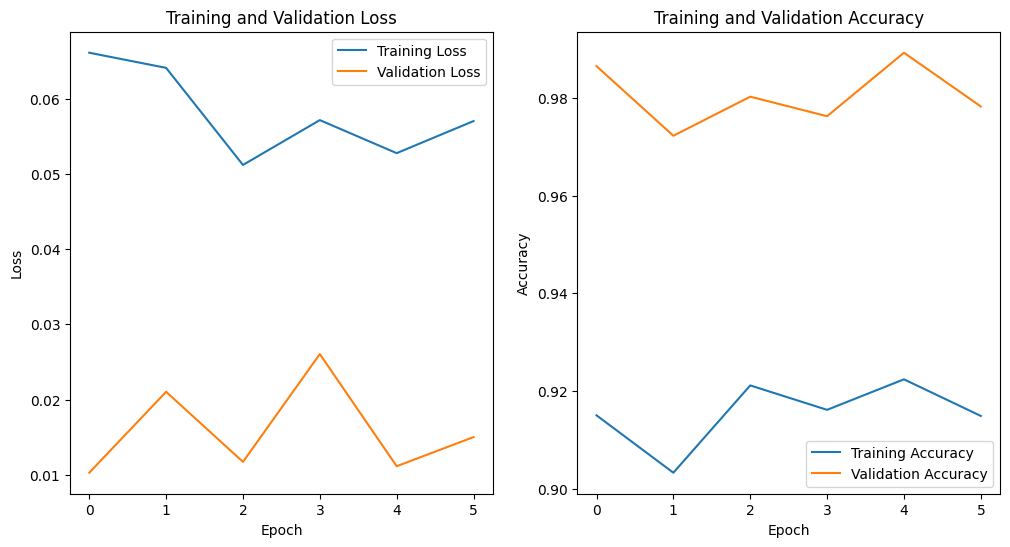

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_tuner.history['loss'], label='Training Loss')
plt.plot(history_tuner.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tuner.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuner.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
predicted_labels3 = []
true_labels3 = []

In [ ]:
for label3 in test_labels:
    class_dir3 = os.path.join(test_d, label3)
    image_files3 = os.listdir(class_dir3)

    for image_file3 in image_files3:  # Use image_files3 instead of image_files
        image_path3 = os.path.join(class_dir3, image_file3)
        image3 = Image.open(image_path3).convert("RGB")  # Convert to RGB
        image3 = image3.resize((256, 256))  # Resize to match model input shape
        image_array3 = np.array(image3) / 255.0  # Normalize pixel values
        image_input3 = np.expand_dims(image_array3, axis=0)  # Add batch dimension

        predicted_probabilities3 = best_model.predict(image_input3)
        predicted_class_index3 = np.argmax(predicted_probabilities3)
        predicted_class_label3 = class_labels[predicted_class_index3]

        true_labels3.append(label3)
        predicted_labels3.append(predicted_class_label3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━

In [ ]:
predicted_labels3 = np.array(predicted_labels3)
true_labels3 = np.array(true_labels3)

In [ ]:
accuracy_model3 = np.mean(predicted_labels3 == true_labels3)
print("Test Accuracy:", accuracy_model3)

Test Accuracy: 0.9885


## My Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


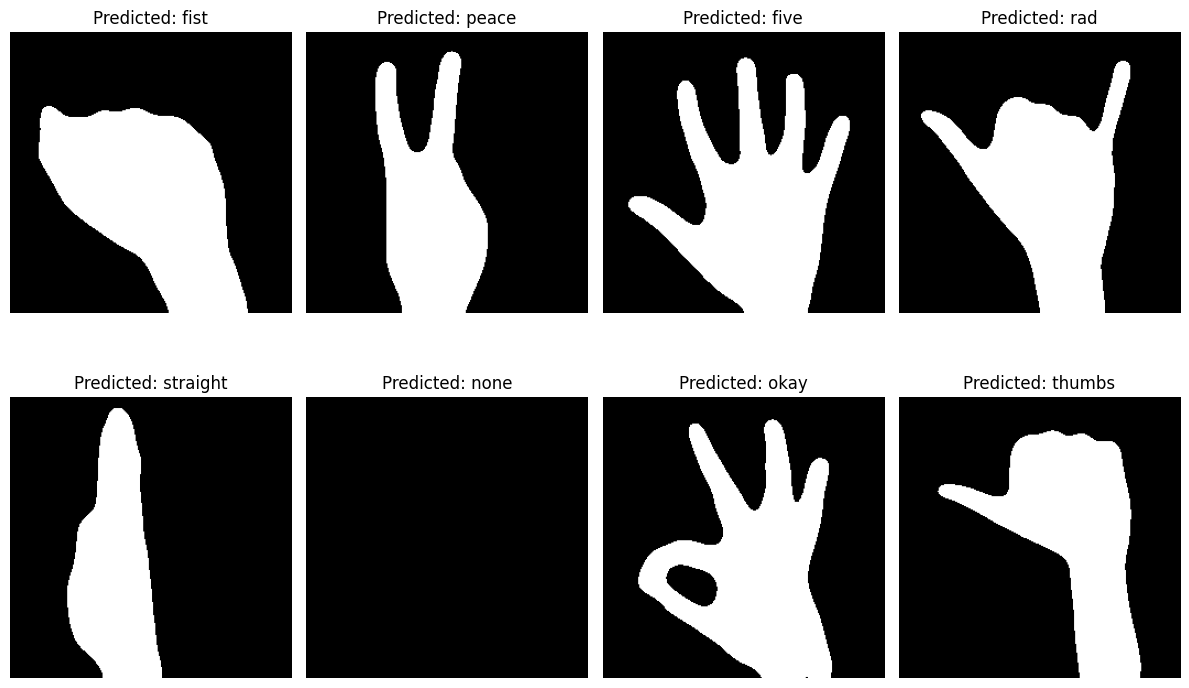

In [ ]:
new_test_dir = 'Data/New_test'
plt.figure(figsize=(12, 8))
for i, image_file in enumerate(os.listdir(new_test_dir), start=1):
    image_path = os.path.join(new_test_dir, image_file)
    image = Image.open(image_path).convert("RGB")  # Convert to RGB
    image = image.resize((256, 256))  # Resize to match model input shape
    image_array = np.array(image) / 255.0  # Normalize pixel values
    image_input = np.expand_dims(image_array, axis=0)  # Add batch dimension
    predicted_probabilities = best_model.predict(image_input)
    predicted_class_index = np.argmax(predicted_probabilities)
    predicted_class_label = class_labels[predicted_class_index]
    plt.subplot(2, 4, i)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Comparison

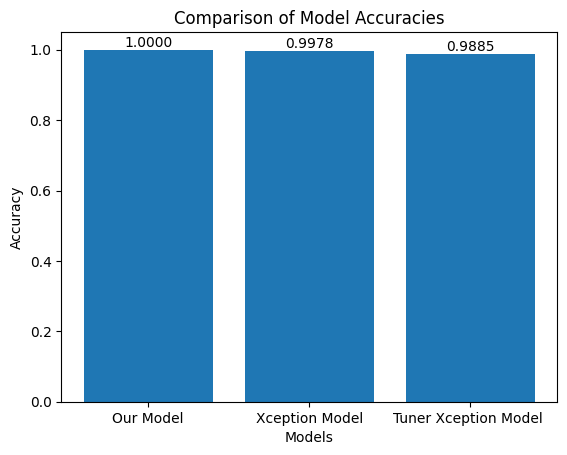

In [ ]:
models = ['Our Model', 'Xception Model', 'Tuner Xception Model ']
accuracies = [accuracy_model, accuracy_model2, accuracy_model3]

plt.bar(models, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

for i in range(len(models)):
    plt.text(i, accuracies[i], f'{accuracies[i]:.4f}', ha='center', va='bottom')